# Unlocking the Palate - Evaluating Taste Consensus Among Beer Reviewers

---

Group [**BlackAda**](https://en.wikipedia.org/wiki/Blackadder)

> - Ludek Cizinsky ([ludek@cizinsky@epfl.ch](ludek.cizinsky@epfl.ch))
> - Peter Nutter ([peter@nutter@epfl.ch](peter@nutter@epfl.ch))
> - Pierre Lardet ([pierre@lardet@epfl.ch](pierre@lardet@epfl.ch))
> - Christian Bastin ([christian@bastin@epfl.ch](christian@bastin@epfl.ch))
> - Mika Senghaas ([mika@senghaas@epfl.ch](mika@senghaas@epfl.ch))

## Introduction

---

Navigating the world of beer reviews can be a daunting task for non-experts. Beer aficionados often describe brews as having nuanced flavors such as "grassy notes" and "biscuity/ crackery malt," with hints of "hay." But do these descriptions reflect the actual tasting experience? Following a "wisdom-of-the-crowd" approach, a descriptor can be considered meaningful if many, independent reviewers use similar descriptors for a beer's taste. To quantify consensus, we use natural language processing techniques to extract descriptors of a beer's taste and numerically represent these descriptors to compute similarity or consensus scores. The consensus scores between beer reviews will unveil whether there is a shared understanding of taste among beer geeks.

## Dependencies

---

We load the dependencies required for this project to run.

In [1]:
# Enable continuous module reloading
%load_ext autoreload
%autoreload 1
%aimport src

# Standard library
import os
import math

# Third party modules
# - Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
colorstyle = "RdBu"
sns.set_palette(colorstyle)
import ipywidgets as widgets

# - Machine learning
# TODO

# - Data analysis
import pandas as pd
import numpy as np

# Custom modules
from src import utils
from src import visualization

And set some global variables.

In [2]:
# URL for the full dataset
DATA_URL = "https://drive.google.com/u/2/uc?id=1IqcAJtYrDB1j40rBY5M-PGp6KNX-E3xq&export=download"

# Number of samples to use for the subset
NUM_SUBSET_SAMPLES = 10000

# Paths
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data")

# Ensure data directory exists
os.makedirs(DATA_DIR, exist_ok=True)

## Data

---

We will be working with the beer review data from the [BeerAdvocate](https://www.beeradvocate.com/) platform. 


### Data Download

Due to its size (uncompressed 1.6 GB), the dataset is not included in the repository but must be downloaded. The course staff has provided the data via Google Drive. On the first run of this notebook, we download the compressed data file from Google Drive and extract it to the `data` folder. The compressed file is ~1.5 GB in size. 

After extraction and removing of unnecessary files (archives, ratings file, ...), the data folder should contain the following files: `beers.csv`, `breweries.csv`, `users.csv`, `reviews.txt`. The total size of the data is ~2.9 GB.

*NB: Data loading takes around **~8min** on the first run. Subsequent runs of this cell are instant.*

In [3]:
# Download the BeerAdvocate dataset if it doesn't exist
if not os.path.exists(os.path.join(DATA_DIR, "reviews.txt")):
    utils.download_data(DATA_URL, data_dir=DATA_DIR)
print(f"Beer reviews downloaded to {DATA_DIR} ✅.")

Beer reviews downloaded to /Users/ludekcizinsky/Dev/personal/ada-2023-project-blackada/data ✅.


### Data Loading

Next, we load the data into a Pandas DataFrame. On the first run, we load all the reviews from the `reviews.txt` file and populate it with some additional meta-data from the other files. We then save the DataFrame to a `.feather` file for faster loading in the future. On subsequent runs, we load the DataFrame from the `.feather` file if it exists.

*NB: Running this cell for the first time reads in all `2.5M` reviews which takes **~7min**. Subsequent runs should be much faster, taking about **~1min**.*

In [4]:
# Load all reviews and a subset of reviews (10,000)
reviews = utils.load_data(DATA_DIR)
sub_reviews = utils.load_data(DATA_DIR, num_samples=NUM_SUBSET_SAMPLES)

print(f"Loaded {len(reviews)} reviews ✅. (+{len(sub_reviews)} reviews in subset)")

Loaded 2589586 reviews ✅. (+10000 reviews in subset)


### EDA

Let's explore the data a bit. First, we will select whether we want to investigate the whole sample or a subset of it.

In [5]:
df = reviews.copy(deep=True)
print("There is a total of {} reviews.".format(len(df)))
df.head()

There is a total of 2589586 reviews.


beer                                                                \
       id           name             style  abv nbr_ratings nbr_reviews   
0  142544          Régab   Euro Pale Lager  4.5           1           1   
1   19590  Barelegs Brew  English Pale Ale  4.5           4           4   
2   19590  Barelegs Brew  English Pale Ale  4.5           4           4   
3   19590  Barelegs Brew  English Pale Ale  4.5           4           4   
4   19590  Barelegs Brew  English Pale Ale  4.5           4           4   

  brewery                                                               \
       id                                       name          location   
0   37262  Societe des Brasseries du Gabon (SOBRAGA)             Gabon   
1   10093       Strangford Lough Brewing Company Ltd  Northern Ireland   
2   10093       Strangford Lough Brewing Company Ltd  Northern Ireland   
3   10093       Strangford Lough Brewing Company Ltd  Northern Ireland   
4   10093       Strangford Lough Brewing Company Ltd  Northern Ireland   

             ...                user                                review  \
  nbr_beers  ...              joined                   location appearance   
0         1  ... 2008-01-07 11:00:00  United States, Washington       3.25   
1         5  ... 2007-10-08 10:00:00    United States, New York       3.00   
2         5  ... 2005-05-18 10:00:00           Northern Ireland       4.00   
3         5  ... 2004-11-25 11:00:00           Northern Ireland       4.00   
4         5  ... 2003-11-20 11:00:00           Northern Ireland       4.00   

                                     \
  aroma palate taste overall rating   
0  2.75   3.25  2.75     3.0   2.88   
1  3.50   3.50  4.00     3.5   3.67   
2  3.50   3.50  4.00     3.5   3.73   
3  3.50   4.00  4.00     4.5   3.98   
4  4.00   4.00  4.00     4.0   4.00   

                                                                          
                                                text                date  
0  From a bottle, pours a piss yellow color with ... 2015-08-20 10:00:00  
1  Pours pale copper with a thin head that quickl... 2009-02-20 11:00:00  
2  500ml Bottle bought from The Vintage, Antrim..... 2006-03-13 11:00:00  
3  Serving: 500ml brown bottlePour: Good head wit... 2004-12-01 11:00:00  
4  500ml bottlePours with a light, slightly hazy ... 2004-08-30 10:00:00  

[5 rows x 24 columns]

#### Beer

In [6]:
df.beer.head()

,id,name,style,abv,nbr_ratings,nbr_reviews
0,142544,Régab,Euro Pale Lager,4.5,1,1
1,19590,Barelegs Brew,English Pale Ale,4.5,4,4
2,19590,Barelegs Brew,English Pale Ale,4.5,4,4
3,19590,Barelegs Brew,English Pale Ale,4.5,4,4
4,19590,Barelegs Brew,English Pale Ale,4.5,4,4


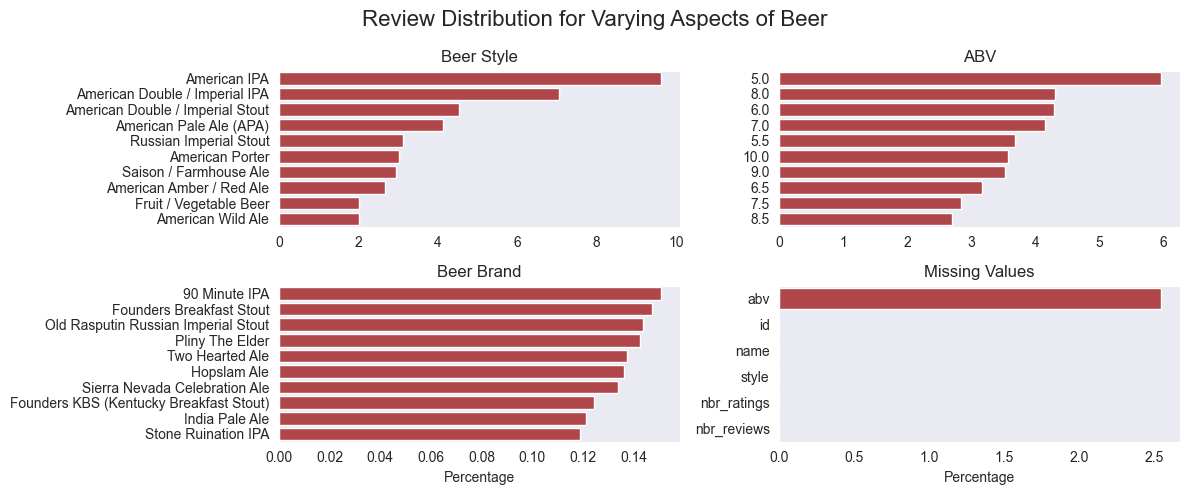

In [7]:
# Compute distribution of beer styles in percentage
beer_style_dist = df["beer"]["style"].value_counts(normalize=True) * 100
beer_style_dist = beer_style_dist[:10]

# Compute of abv in percentage
abv_dist = df["beer"]["abv"].astype(str).value_counts(normalize=True) * 100
abv_dist = abv_dist.iloc[:10]

# Compute distribition of beers
beer_name_dist = df["beer"]["name"].value_counts(normalize=True) * 100
beer_name_dist = beer_name_dist[:10]

# Compute distribution of missing values for beer
beer_missing_dist = df["beer"].isnull().mean() * 100
beer_missing_dist = beer_missing_dist.sort_values(ascending=False)
beer_missing_dist.index.name = "column"

# Using seaborn, plot all the computed distributions
fig, ax = plt.subplots(2, 2, figsize=(12, 5), sharex=False)
sns.barplot(x=beer_style_dist.values, y=beer_style_dist.index, ax=ax[0][0])
sns.barplot(x=abv_dist.values, y=abv_dist.index, ax=ax[0][1], orient="h")
sns.barplot(x=beer_name_dist.values, y=beer_name_dist.index, ax=ax[1][0])
sns.barplot(x=beer_missing_dist.values, y=beer_missing_dist.index, ax=ax[1][1], orient="h")
ax[0][0].set_title("Beer Style");
ax[0][1].set_title("ABV");
ax[1][0].set_title("Beer Brand");
ax[1][1].set_title("Missing Values");

# Set xlabel
ax[1][0].set_xlabel("Percentage");
ax[1][1].set_xlabel("Percentage");

# Turn off y-axis for all plots
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel("");

# Set title for the entire figure
fig.suptitle("Review Distribution for Varying Aspects of Beer", fontsize=16);

# Set tight layout
plt.tight_layout()

#### Breweries

In [8]:
df.brewery.head()

,id,name,location,nbr_beers
0,37262,Societe des Brasseries du Gabon (SOBRAGA),Gabon,1
1,10093,Strangford Lough Brewing Company Ltd,Northern Ireland,5
2,10093,Strangford Lough Brewing Company Ltd,Northern Ireland,5
3,10093,Strangford Lough Brewing Company Ltd,Northern Ireland,5
4,10093,Strangford Lough Brewing Company Ltd,Northern Ireland,5


In [9]:
# Get unique breweries
unique_breweries = df.brewery.drop_duplicates()
print(f"There are {len(unique_breweries)} unique breweries in the dataset.")

There are 11968 unique breweries in the dataset.


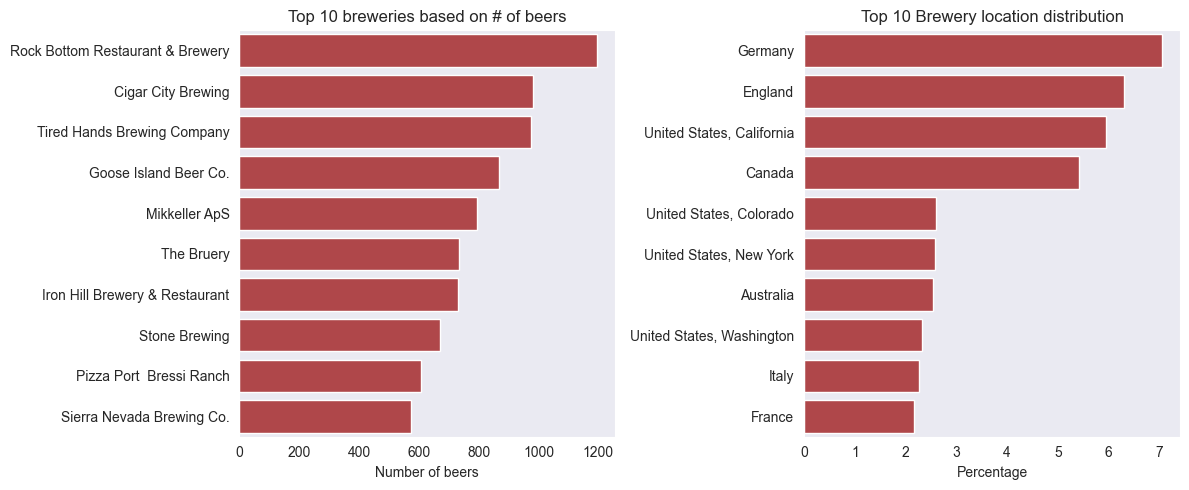

In [10]:
# Sort by nbr of beers
unique_breweries = unique_breweries.sort_values(by="nbr_beers", ascending=False)
top_breweries = unique_breweries.iloc[:10]

# Get the distribution of the location of the breweries
brewery_location_dist = unique_breweries.location.value_counts(normalize=True) * 100
brewery_location_dist = brewery_location_dist.iloc[:10]

# Plot the distribution of the location of the breweries
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=top_breweries.nbr_beers, y=top_breweries.name, ax=ax[0])
sns.barplot(x=brewery_location_dist.values, y=brewery_location_dist.index, ax=ax[1])

# Set titles
ax[0].set_title("Top 10 breweries based on # of beers");
ax[1].set_title("Top 10 Brewery location distribution");

# Set labels
ax[0].set_xlabel("Number of beers");
ax[0].set_ylabel("");
ax[1].set_ylabel("");
ax[1].set_xlabel("Percentage");

# Set tight layout
plt.tight_layout()


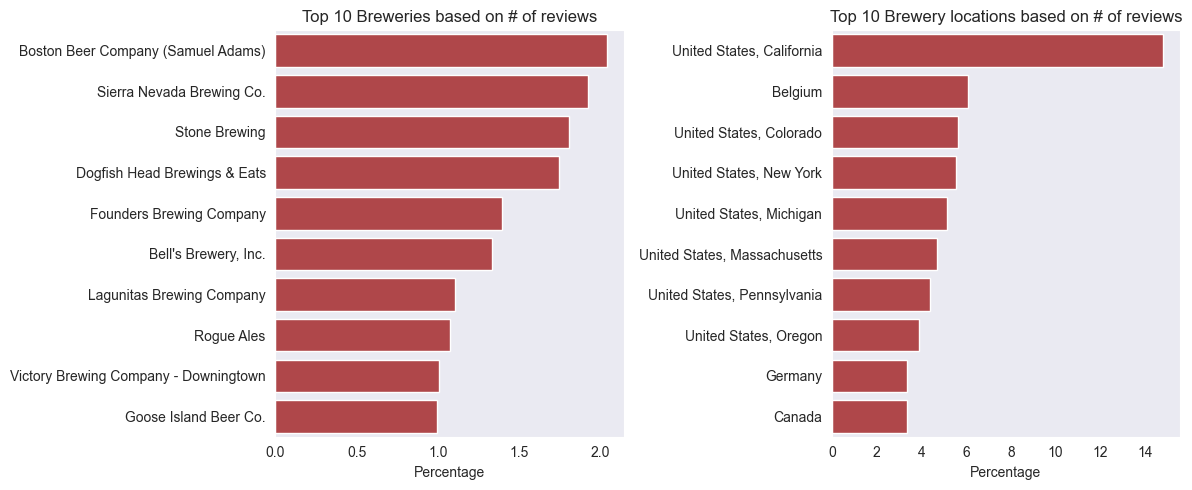

In [11]:
# Compute top 10 breweries based on number of reviews in percentage
brewery_review_dist = df["brewery"]["name"].value_counts(normalize=True) * 100
brewery_review_dist = brewery_review_dist.iloc[:10]

# Compute top 10 brewery location based on number of reviews in percentage
brewery_location_dist = df["brewery"]["location"].value_counts(normalize=True) * 100
brewery_location_dist = brewery_location_dist.iloc[:10]

# Plot the distribution of the location of the breweries
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=brewery_review_dist.values, y=brewery_review_dist.index, ax=ax[0])
sns.barplot(x=brewery_location_dist.values, y=brewery_location_dist.index, ax=ax[1])

# Set titles
ax[0].set_title("Top 10 Breweries based on # of reviews");
ax[1].set_title("Top 10 Brewery locations based on # of reviews");

# Set labels
ax[0].set_xlabel("Percentage");
ax[0].set_ylabel("");
ax[1].set_ylabel("");
ax[1].set_xlabel("Percentage");

# Set tight layout
plt.tight_layout()

#### Users

In [12]:
df.user.head()

,id,name,nbr_ratings,nbr_reviews,joined,location
0,nmann08.184925,nmann08,7820,465,2008-01-07 11:00:00,"United States, Washington"
1,stjamesgate.163714,StJamesGate,2521,2504,2007-10-08 10:00:00,"United States, New York"
2,mdagnew.19527,mdagnew,1797,1143,2005-05-18 10:00:00,Northern Ireland
3,helloloser12345.10867,helloloser12345,31,31,2004-11-25 11:00:00,Northern Ireland
4,cypressbob.3708,cypressbob,604,604,2003-11-20 11:00:00,Northern Ireland


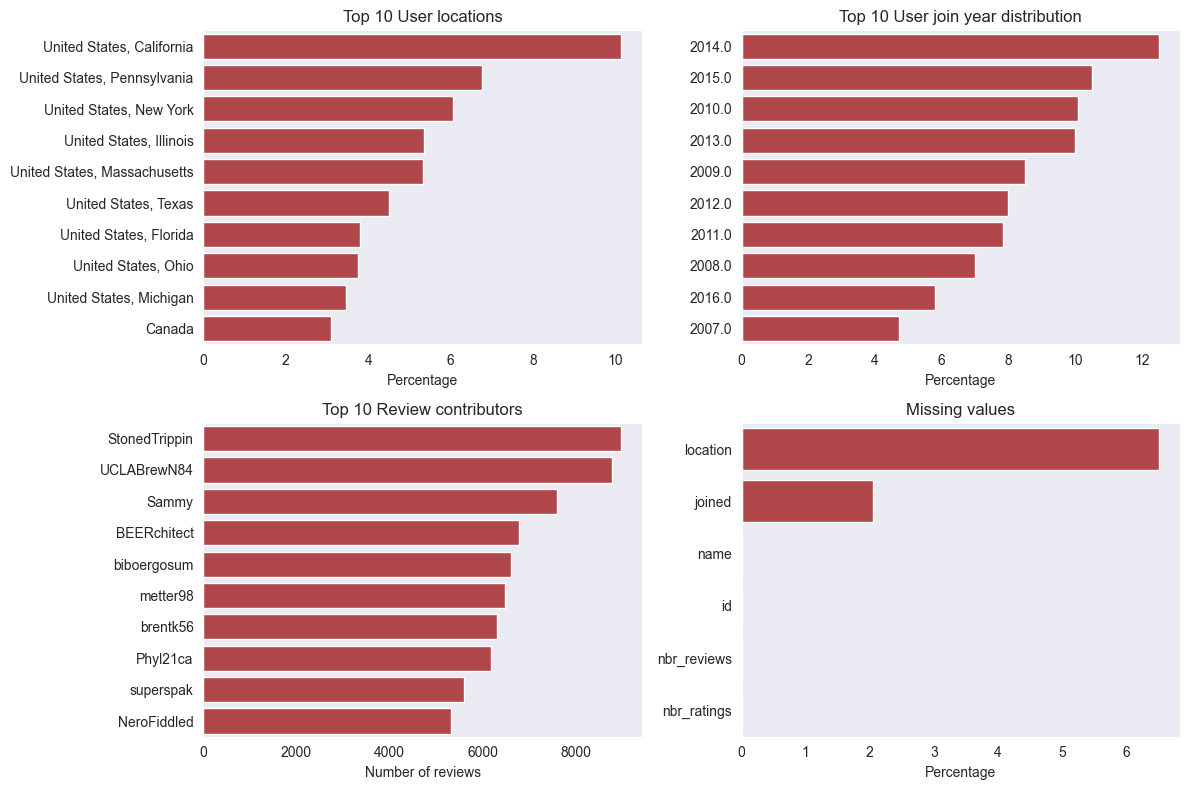

In [13]:
# Get unique users
unique_users = df.user.drop_duplicates()

# Get the distribution of the location of the users
user_location_dist = unique_users.location.value_counts(normalize=True) * 100
user_location_dist = user_location_dist.iloc[:10]

# Get the distribution of the year in which users joined
user_year_dist = unique_users.joined.dt.year.astype(str).value_counts(normalize=True) * 100
user_year_dist = user_year_dist.iloc[:10]

# Show the top review contributors
top_review_contributors = unique_users.sort_values(by="nbr_reviews", ascending=False).iloc[:10]

# Get the missing values distribution
user_missing_dist = unique_users.isnull().mean() * 100
user_missing_dist = user_missing_dist.sort_values(ascending=False)

# Plot the data
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.barplot(x=user_location_dist.values, y=user_location_dist.index, ax=ax[0][0])
sns.barplot(x=user_year_dist.values, y=user_year_dist.index, ax=ax[0][1])
sns.barplot(x=top_review_contributors.nbr_reviews, y=top_review_contributors.name, ax=ax[1][0])
sns.barplot(x=user_missing_dist.values, y=user_missing_dist.index, ax=ax[1][1])

# Set labels
ax[0][0].set_xlabel("Percentage");
ax[0][1].set_xlabel("Percentage");
ax[1][0].set_xlabel("Number of reviews");
ax[1][1].set_xlabel("Percentage");

# Turn off y-axis for all plots
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel("");


# Set titles
ax[0][0].set_title("Top 10 User locations");
ax[0][1].set_title("Top 10 User join year distribution");
ax[1][0].set_title("Top 10 Review contributors");
ax[1][1].set_title("Missing values");

# Tight layout
plt.tight_layout()

There are 62252 unique users in the dataset.


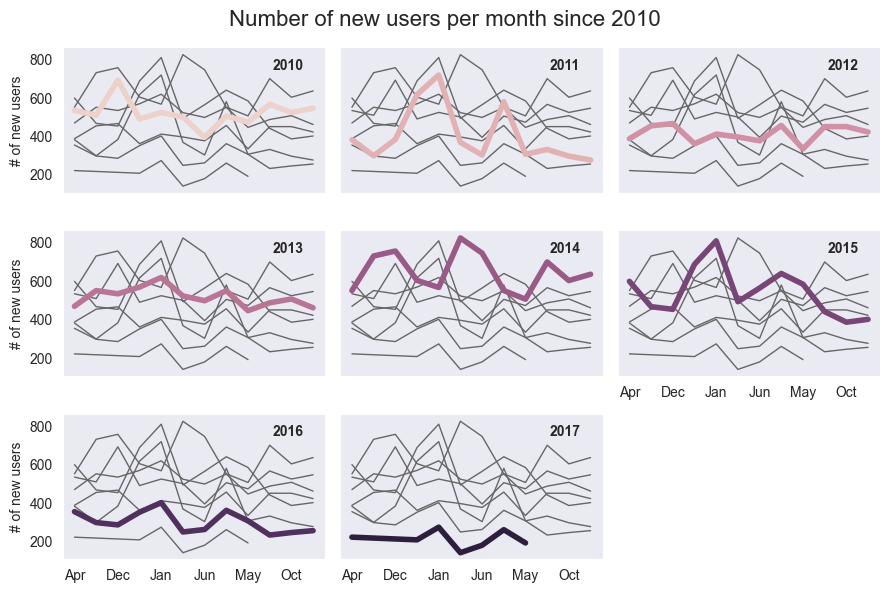

In [14]:
# Get unique users
unique_users = df.user.drop_duplicates()
print(f"There are {len(unique_users)} unique users in the dataset.")

# Extract yead and month of user joined and then create new df with these columns
years = unique_users.joined.dt.year
months = unique_users.joined.dt.month
joined = pd.concat([years, months], axis=1)
joined.columns = ["year", "month"]

# Map the month number to the month name
joined.month = joined.month.map({
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
    5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
    9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec",
})

# Subset the data to only include users who joined in yearX or later
joined = joined[joined.year >= 2010]

# Group by year and month and count the number of users in each group
joined = joined.groupby(["year", "month"]).size().reset_index()
joined.columns = ["year", "month", "count"]

g = sns.relplot(
    data=joined,
    x="month", y="count", col="year", hue="year",
    kind="line", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, int(year), transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=joined, x="month", y="count", units="year",
        estimator=None, color=".4", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "# of new users")
g.tight_layout();

# Set the title
g.fig.suptitle("Number of new users per month since 2010", fontsize=16);

# Tight layout
plt.tight_layout()

#### Reviews

In [15]:
print(f"There is total of {len(df)} reviews in the dataset.")
reviews.review.head()

There is total of 2589586 reviews in the dataset.


,appearance,aroma,palate,taste,overall,rating,text,date
0,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",2015-08-20 10:00:00
1,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,2009-02-20 11:00:00
2,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",2006-03-13 11:00:00
3,4.00,3.50,4.00,4.00,4.5,3.98,Serving: 500ml brown bottlePour: Good head wit...,2004-12-01 11:00:00
4,4.00,4.00,4.00,4.00,4.0,4.00,"500ml bottlePours with a light, slightly hazy ...",2004-08-30 10:00:00


In [16]:
visualize_rating, rating_selector, year_selector = visualization.display_rating_intime(df)
ui = widgets.HBox([rating_selector, year_selector])  
out = widgets.interactive_output(visualize_rating, {'rating': rating_selector, 'yearx': year_selector})
display(ui, out)

Output()